In [1]:
# ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 12: Getting Back to Basics: The Music21Object

Almost everything that we've been working with so far, `Note` objects, `Chord` objects, `Stream` objects, etc., are subclasses of a object that, for lack of a better name, is called :class:`~music21.base.Music21Object`. 

A `Music21Object` is something that can go in a `Stream`, knows where it is in a Stream, and has a `Duration` at `.duration`.  

Of course, not every object in Python is a `Music21Object`, but a little surprisingly, not every object in `music21` is a "`Music21Object`". For instance, the :class:`~music21.pitch.Pitch` object is not. If you try to put one in a `Stream`, you'll get an error:

In [2]:
from music21 import *

p = pitch.Pitch("A-2")
s = stream.Stream()
s.insert(0, p)

StreamException: to put a non Music21Object in a stream, create a music21.ElementWrapper for the item

:class:`~music21.duration.Duration`s are also not `Music21Objects`:

In [3]:
d = duration.Duration('half')
s.insert(0, d)

StreamException: to put a non Music21Object in a stream, create a music21.ElementWrapper for the item

Why don't we just make everything a `Music21Object`? There's an overhead in making a Music21Object, so if we did that, the system would probably run about 10x slower than it does. But there's no reason to put a `Pitch` or a `Duration` in a Stream, when a `Note` is basically a `Pitch` plus a `Duration`.  This works much better:

In [4]:
n = note.Note('A-2', type='half')
s.insert(0, n)
s.show('text')

{0.0} <music21.note.Note A->


How can we tell that a `Note` is a `Music21Object`? Well we can read the docs (:class:`~music21.note.Note`) where it says:

**Note** `bases`:
    
    * NotRest
    * GeneralNote
    * Music21Object
    
Or we can use the `isinstance(obj, class)` operator on a given note. The class we are looking for is `base.Music21Object`. We still have our A♭ as `n`, so we can do:

In [5]:
isinstance(n, base.Music21Object)

True

Note that we need to have a Note object first, we can't test the class itself:

In [6]:
isinstance(note.Note, base.Music21Object)

False

There's one other way that you can tell if an object is a `Music21Object`, that's to check whether `Music21Object` appears in the object's `.classes`:

In [7]:
'Music21Object' in n.classes

True

But that's a bit of a cop-out.  Things that are not `Music21Objects` don't generally have a `.classes` property, so that won't work:

In [8]:
import datetime
dt = datetime.datetime(2015, 9, 27)
dt

datetime.datetime(2015, 9, 27, 0, 0)

In [9]:
'Music21Object' in dt.classes

AttributeError: 'datetime.datetime' object has no attribute 'classes'

But it's a useful and easy way of checking to see if something you know *is* a `Music21Object` is a specific class:

In [10]:
'Chord' in n.classes

False

In fact, it's useful enough that we've put it in a few objects in `music21` that aren't `Music21Objects`

In [11]:
'Duration' in d.classes

True

The class of an object cannot (well, should not) change after it's been created.  Thus it can be thought of as totally stable. Streams have many ways of filtering out `Music21Object`s (a.k.a. "elements") according to class.  The easiest way is with `.getElementsByClass`:

In [12]:
s = stream.Stream()
s.append(clef.TrebleClef())
s.append(meter.TimeSignature('3/4'))
s.append(note.Note("A"))
s.append(note.Rest())
s.append(note.Note("B"))

for element in s.getElementsByClass('Note'):
    print(element)

<music21.note.Note A>
<music21.note.Note B>


If you wanted to get the Notes and the Rest, you could figure out what their common ancestor class is and filter on that:

In [13]:
(note.Rest().classes, note.Note().classes)

(('Rest', 'GeneralNote', 'Music21Object', 'object'),
 ('Note', 'NotRest', 'GeneralNote', 'Music21Object', 'object'))

In [14]:
for element in s.getElementsByClass('GeneralNote'):
    print(element)

<music21.note.Note A>
<music21.note.Rest rest>
<music21.note.Note B>


Or you could give a list of relevant classes:

In [15]:
for element in s.getElementsByClass(['Note', 'Rest']):
    print(element)

<music21.note.Note A>
<music21.note.Rest rest>
<music21.note.Note B>


For those who are familiar with HTML/Javascript/DOM programming, a Python Class is most similar to a DOM Tag (like &lt;img&gt;). So DOM methods such as `.getElementsByTagName` are similar to `music21`'s `.getElementsByClass`.

It's worth pointing out that there's also a `.classSet` (v.2.1+) on every `Music21Object` that gives the string name of all base classes, the fully-qualified string name for every class, as well as the class object.  Since it will return `True` for basically every form that someone might pass in a class selector, it's used a lot internally for safety. It returns these objects as a `frozenset()`, meaning it will return in any order and cannot be manipulated:

In [16]:
r = note.Rest()
r.classSet

frozenset({'music21.base.Music21Object',
           object,
           'music21.note.Rest',
           music21.note.GeneralNote,
           'Music21Object',
           'Rest',
           'builtins.object',
           music21.note.Rest,
           'music21.note.GeneralNote',
           'object',
           'GeneralNote',
           music21.base.Music21Object})

In [17]:
('Rest' in r.classSet, 'music21.note.GeneralNote' in r.classSet, base.Music21Object in r.classSet)

(True, True, True)

## Attributes and Properties

Once you know that something is a `music21Object` you can exploit the attributes of the object for musical purposes.

### `id`

Each `music21Object` has a (should be) unique id stored in the `.id` attribute:

In [18]:
n = note.Note("C#4")
n.id

4513862936

By default, this `.id` is the same as the location of the object in memory, which the built-in Python function `id()` returns:

In [19]:
id(n)

4513862936

But we can set it manually so that the object is easier to find later:

In [20]:
n.id = 'first_note'
n.id

'first_note'

We advise `.id` not to include spaces or special characters, and may enforce it in the future.

This `.id` is especially useful for `Stream` objects because it will be displayed in the representation of the Stream and, if there's no other metadata, can be used as the name of the part:

In [21]:
s = stream.Stream()
s.id = 'empty_stream'
s

<music21.stream.Stream empty_stream>

Parts can be retrieved from the `.parts` attribute of a score by id.

In [22]:
bach = corpus.parse('bwv66.6')
sopr = bach.parts['soprano']
sopr

<music21.stream.Part Soprano>

In [23]:
sopr.id

'Soprano'

There are some properties such as `.getElementById()` that retrieve objects by `.id`:

In [24]:
s.append(n)
x = s.getElementById('first_note')
print(x, x.id)

<music21.note.Note C#> first_note


If you know HTML/Javascript/DOM programming, the similarity between `music21`'s `.getElementById()` and HTML's `.getElementById()` is intentional.

### Groups

A group is a collection of labels for an object.  Think of :class:`~music21.base.Groups` as being like `.id` with two differences: (1) each `Music21Object` can have zero, one, or multiple Groups -- but it has exactly one `.id` and (2) a single group label can belong to multiple `Music21Objects`.

In [25]:
n.groups

[]

`Groups` are wrappers around lists that enforce the restriction that the label must be a string.  Since they're otherwise just lists, you can add a group to any object just by appending a string to the group:

In [26]:
n.groups.append('black_key')
n.groups.append('sharped')
n.groups

['black_key', 'sharped']

We advise groups not to have spaces in them and will be enforcing this in v.3.

Now we can search through Streams that `n` is in to find it by searching for the group `'sharped'` (or `'black key'`). We use `Stream.getElementsByGroup()`.  Note that it is plural `Elements` while the previous call was `getElementById` singular. That's because there should be only one object with each id but there could be many with the same group:

In [27]:
for x in s.iter.getElementsByGroup('sharped'):
    print(x, x.id)

<music21.note.Note C#> first_note


`Groups` are the equivalent of the HTML/Javascript/DOM "class".  (Since `class` means something else in Python, we've changed the term).  Eventually, `Groups` will be able to be used in styling objects automatically.  For now we can just do it by hand:

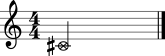

In [28]:
for x in s.iter.getElementsByGroup('black_key'):
    x.notehead = 'circle-x'
    
s.show()

### ActiveSite

A `Music21Object` that is inside one or more Streams should be able to get its most recently stream via its `.activeSite` attribute.  We've put `n` in `s`, which is called (now incorrectly) `'empty stream'`, so n's `.activeSite` should be `s`.

In [29]:
n.activeSite

<music21.stream.Stream empty_stream>

The activeSite may change over time; obviously if the note is put in another Stream then that Stream will become the activeSite.  Let's put the note in a new stream, four quarter notes from the start:

In [30]:
t = stream.Stream()
t.id = 'new_stream'
t.insert(4.0, n)

n.activeSite

<music21.stream.Stream new_stream>

We can also change the activeSite...

In [31]:
n.activeSite = s
n.activeSite

<music21.stream.Stream empty_stream>

As long as it is a Stream that the Element is already a part of:

In [32]:
q = stream.Stream(id='unrelated_stream')
n.activeSite = q

SitesException: v2.1. -- you may not assign an activesite for an object <music21.note.Note C#> not in the Stream <music21.stream.Stream unrelated_stream>

Newly created objects have an `.activeSite` of `None`

In [33]:
m = note.Rest()
m.activeSite is None

True

The `.activeSite` of an object will determine which other objects it is connected to, where it thinks it is, etc. The best way to demonstrate that is with the next attribute...

### offset

The `.offset` of a `Music21Object` is the number of quarter notes from the start of the Stream it is a part of. The Stream that is referenced is the `.activeSite`. Remember that `n` was inserted at offset 0 of `s` (`'empty stream'`) and offset 4 of `t` (`'new stream'`):

In [34]:
n.activeSite = s
n.offset

0.0

In [35]:
n.activeSite = t
n.offset

4.0

If we change the offset of the `Note` it changes it in the `Stream`, so that if we change the activeSite away and back, the offset is preserved. It's more easily demonstrated than explained in words:

In [36]:
n.activeSite = s
n.offset = 2.0
n.activeSite = t
n.activeSite = s
n.offset

2.0

A newly created `Music21Object` has a great advantage -- it can set its offset to anything it wants and then when it is inserted into a Stream with a single argument, it appears at that offset.

In [37]:
n2 = note.Note('G-2')
n2.offset = 20.0
s.insert(n2)
n2.activeSite

<music21.stream.Stream empty_stream>

In [38]:
n2.offset

20.0

### priority

If you have a Stream with two elements at the same offset, how can you know which one of them should come first? The easiest way to ensure that one comes before the other is to change the `.priority` of one of them.  `.priority` is any integer, with a default of zero.  Let's create some a new Stream and some notes:

In [39]:
s = stream.Stream()
d = note.Note('D4')
e = note.Note('E4')
s.insert(0.0, d)
s.insert(0.0, e)
s.show('text')

{0.0} <music21.note.Note D>
{0.0} <music21.note.Note E>


Both notes are at offset 0, but D was inserted first, so it comes first.  But we can move E by making it's `.priority` lower than D's:

In [40]:
d.priority

0

In [41]:
e.priority = -1
s.show('text')

{0.0} <music21.note.Note E>
{0.0} <music21.note.Note D>


If we return e's priority to the default of `0`, it will again appear after d:

In [42]:
e.priority = 0
s.show('text')

{0.0} <music21.note.Note D>
{0.0} <music21.note.Note E>


### classSortOrder

Objects seem to be sorted by offset first, then priority, then when they were inserted. But what about this:

In [43]:
tc = clef.TrebleClef()
s.insert(0.0, tc)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.note.Note D>
{0.0} <music21.note.Note E>


How did the Stream (correctly) know that the treble clef should come first?  It's not because of its priority:

In [44]:
(tc.priority, d.priority, e.priority)

(0, 0, 0)

It's because there is another property that aids in sorting, and that is called `.classSortOrder`.  We can see that `c`, our treble clef, has a lower `.classSortOrder` than `d` and `e` by virtue of being of the class `Clef`:

In [45]:
(tc.classSortOrder, d.classSortOrder, e.classSortOrder)

(0, 20, 20)

`.classSortOrder` is like `.priority` in that lower numbers come first.  We've arbitrarily placed Clef at `0` and Note at `20` and lots of other Classes in between.  `.classSortOrder` is what is called a Class Attribute, meaning that the class objects have this attribute set:

In [46]:
(clef.TrebleClef.classSortOrder, note.Note.classSortOrder)

(0, 20)

And any change in `.classSortOrder` applied to the class changes it for all its members:

In [47]:
clef.TrebleClef.classSortOrder = 25
note.Note.classSortOrder = 10
(tc.classSortOrder, d.classSortOrder, e.classSortOrder)

(25, 10, 10)

But don't do that! For one thing, the ordering of existing Streams is not changed, for another, we've carefully balanced the `classSortOrder` so that musically logical order is maintained (have you ever seen a score where the first note comes before the first clef?).  So we'll change it back here.

In [48]:
clef.TrebleClef.classSortOrder = 0
note.Note.classSortOrder = 20
(tc.classSortOrder, d.classSortOrder, e.classSortOrder)

(0, 20, 20)

If you do need to do something wacky, like have notes before clefs, you can always change the `.priority` instead.

For more information about how sorting works, jump to :ref:`Chapter 21: Ordering and Sorting of Stream Elements <usersGuide_21_sorting>`

That seems like a good place for a break. We've got some more to cover, so I've split this chapter into two parts, we'll continue in :ref:`Chapter 13: More Music21Object Attributes and Methods<usersGuide_13_music21object2>`